In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh
from scipy.special import softmax
import ipdb


In [2]:
class Regression:
    def __initial__(self):
        pass
    
    def X_arg(self,X):
        N, _ = X.shape
        X = np.concatenate((np.ones((N,1)),X), axis=1)
        return X
    
    def scalar(self,X):
        X_mean = np.mean(X,axis=0)
        X_std = np.std(X,axis=0)
        X = (X-X_mean)/X_std
        return X_mean, X_std      
    
    def OLS(self, X, Y, *arg):
        beta_hat = np.linalg.inv(X.T@X)@X.T@(Y-np.mean(Y,0))       
        beta_hat = np.insert(beta_hat,0,np.mean(Y,0),0)
        return beta_hat


In [3]:
class classification():
    def __init__(self,n_component =2 ):
        self.n_component = n_component
        
    
    def LDA(self,X,label):
        N, p = np.shape(X)
        self.label_list, _ = np.unique(y_train, return_inverse=True) 
        self.cov_ = []
        self.m = np.mean(X, 0).reshape((1,p))
        St = np.cov(X.T, bias=1)
        _, label_t = np.unique(label, return_inverse=True) 
        self.w = np.bincount(label_t)/float(len(label))
        
        for i in self.label_list:
            ind = label == i
            self.cov_.append(np.cov(X[ind,:].T, bias=1))
        
        Sw = np.average(self.cov_, axis=0, weights=self.w)
        self.cova = Sw
        Sb = St - Sw
        eigvals, self.eigvecs = eigh(Sb, Sw)

       
        idx = eigvals.argsort()[::-1]   
        eigvals = eigvals[idx]
        self.eigvecs = self.eigvecs[:,idx]
        v = (X-self.m)@self.eigvecs
        self.wmean = np.zeros((len(self.label_list),self.n_component))
        self.wcov = np.zeros((p,p,len(self.label_list)))
        self.cmean = np.zeros((len(self.label_list),p))
        for i in label:
            self.wmean[i-1,:] = np.array([np.mean(v[label == i,0:self.n_component],0)])
            self.cmean[i-1,:] = np.array([np.mean(X[label == i,:],0)])
            self.wcov[:,:,i-1] = np.cov(v[label == i,:].T) 
        self.coef_ = self.cmean@self.eigvecs@self.eigvecs.T
        self.intercept_ = -0.5 * np.diag(self.cmean@self.coef_.T) + np.log(self.w)

        return  v[:,0:self.n_component]
    def LDA_trasform(self,X):
        v = (X-self.m)@self.eigvecs
        return v   

    
    def LDA_pred(self,X):
        return self.label_list[np.argmax((X@self.coef_.T+self.intercept_),1)] #Linear score function        

    
    def QDA(self,X,label,alpha = 1):
        _ = self.LDA(X,label)
        N, p = np.shape(X)
        self.cmean_QDA = self.cmean
        self.w_QDA = self.w
        self.cov_QDA = []
        for i in np.arange(0,len(self.label_list)):
            self.cov_QDA.append(alpha*self.cov_[:][:][i] + (1-alpha)*self.cova)
        score = []

    def QDA_prd(self,X):
        score = []

        for i in self.label_list:
            score.append(-1/2*np.diag((X-self.cmean_QDA[i-1,:])@np.linalg.inv(self.cov_QDA[:][:][i-1])@(X-self.cmean_QDA[i-1,:]).T)-\
                     1/2*np.log(np.linalg.det(self.cov_QDA[:][:][i-1]))+1/2*np.log(self.w_QDA[i-1]))
        return score
    
    def Log(self,X,label,mu = 0.01,max_iter=1000, eta = 0.1):
        
        self.label_list, _ = np.unique(label, return_inverse=True) 
        label = self.OneHotDecoder(label)
        self.W = np.zeros((X.shape[1], label.shape[1]))
        step = 0
        
        while step < max_iter:
            
            
            Z = -X@self.W
            
            Ps = softmax(Z,1)
            N,_ = X.shape
            gd = 1/N*(X.T @ (label-Ps)) + 2*mu*self.W
            self.W = self.W - eta*gd
            step =step + 1
            
    def Log_pred(self, X):
        Z = -X@self.W
        
        return self.label_list[np.argmax(softmax(Z,1),1)]
         
    def OneHotDecoder(self, Y):
        
        self.label_list, _ = np.unique(Y, return_inverse=True) 
        N = len(Y)
        OHM = np.zeros((N,len(self.label_list)))
       
        for i in self.label_list: OHM[Y == i,i-1]=1
        return OHM
        



In [4]:

df = pd.read_csv('Vowel.txt')
list(df)
index_train = df['is_train'] == 1

x_train = df[index_train]
N,p = np.shape(x_train)

x_train = x_train.drop(['row.names','is_train'], axis=1)
y_train = x_train['y'].values.reshape((N,))
x_train = x_train.drop('y', axis=1).values
label_train = np.unique(y_train)

index_test = df['is_train'] == 0

x_test = df[index_test]
N_test,_ = np.shape(x_test)
x_test = x_test.drop(['row.names','is_train'], axis=1)
y_test = x_test['y'].values.reshape((N_test,))
x_test = x_test.drop('y', axis=1).values
label_test = np.unique(y_test)

Y = df['y'].values.reshape((N+N_test,))
X = df.drop(['row.names','is_train','y'], axis=1).values



## Figure 4.4

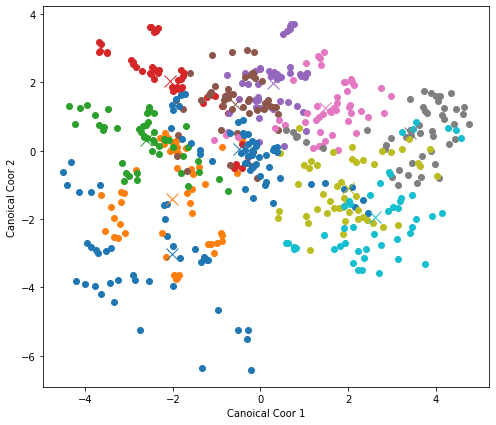

0.32 0.56


In [5]:
MyCla = classification(n_component = 2)
v = MyCla.LDA(x_train,y_train)

fig = plt.figure(figsize=(8,7))
[plt.scatter(v[y_train == i,0],v[y_train == i,1]) for i in label_train]
[plt.plot(np.mean(v[y_train == i,0]),np.mean(v[y_train == i,1]),'x',markersize = 12) for i in label_train]
plt.xlabel('Canoical Coor 1')
plt.ylabel('Canoical Coor 2')
plt.show()

error_LDA_train = np.count_nonzero(MyCla.LDA_pred(x_train)-y_train)/N
error_LDA_test = np.count_nonzero(MyCla.LDA_pred(x_test)-y_test)/N_test
print(f'{error_LDA_train:.2f} {error_LDA_test:.2f}')

In [6]:
MyCla.QDA(x_train,y_train)
error_QDA_train = np.count_nonzero(np.argmax(MyCla.QDA_prd(x_train),0)+1-y_train)/N
error_QDA_test = np.count_nonzero(np.argmax(MyCla.QDA_prd(x_test),0)+1-y_test)/N_test
print(f'{error_QDA_train:.2f} {error_QDA_test:.2f}')


0.01 0.53


## Figure 4.7

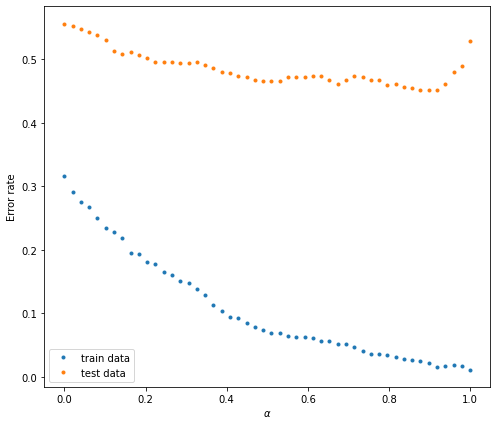

In [7]:
fig, ax = plt.subplots(figsize=(8,7))
error_QDA_train_alpha = []
error_QDA_test_alpha = []
alpha = np.linspace(0, 1, 50)
for i in alpha:
#     ipdb.runcall(MyCla.QDA,x_train,y_train,alpha = i)
    MyCla.QDA(x_train,y_train,alpha = i)
    error_QDA_train_alpha= np.append(error_QDA_train_alpha,np.count_nonzero(np.argmax(MyCla.QDA_prd(x_train),0)+1-y_train)/N)
    error_QDA_test_alpha = np.append(error_QDA_test_alpha,np.count_nonzero(np.argmax(MyCla.QDA_prd(x_test),0)+1-y_test)/N_test)
ax.plot(alpha,error_QDA_train_alpha,'.') 
ax.plot(alpha,error_QDA_test_alpha,'.')
ax.legend(['train data', 'test data'])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'Error rate')
plt.show()

In [8]:
MyReg = Regression()
x_mean, x_std = MyReg.scalar(X)
x_train_sca = (x_train - x_mean)/x_std
x_test_sca = (x_test - x_mean)/x_std

y_train_OHM = MyReg.OneHotDecoder(y_train)

beta_hat_LS = MyReg.OLS((x_train_sca),y_train_OHM)
y_train_LS = MyReg.X_arg(x_train_sca)@beta_hat_LS
y_test_LS = MyReg.X_arg(x_test_sca)@beta_hat_LS
error_OLS_train = np.count_nonzero(np.argmax(y_train_LS,1)+1-y_train)/N
error_OLS_test = np.count_nonzero(np.argmax(y_test_LS,1)+1-y_test)/N_test
print(f'{error_OLS_train:.2f} {error_OLS_test:.2f}')


AttributeError: 'Regression' object has no attribute 'OneHotDecoder'

## Figure 4.10

In [ ]:
fig = plt.figure(figsize=(8,7))
error_test = []
error_train = []
MyCla = classification(n_component = 10)
X_train_reduced = MyCla.LDA(x_train,y_train)
X_test_reduced = MyCla.LDA_trasform(x_test)
for i in np.arange(2,11):
    MyCla = classification(n_component = i)
    _  = MyCla.LDA(X_train_reduced[:,:i],y_train)
    error_train = np.append(error_train,np.count_nonzero(MyCla.LDA_pred(X_train_reduced[:,:i])-y_train)/N)
    error_test = np.append(error_test,np.count_nonzero(MyCla.LDA_pred(X_test_reduced[:,:i])-y_test)/N_test)

plt.plot(np.arange(2,11),error_test,'.-')
plt.plot(np.arange(2,11),error_train,'.-')
plt.ylim([0.2,0.7])
plt.show()

## Figure 4.8

In [ ]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
[axarr[0,0].scatter(X_train_reduced[y_train == i,0],-X_train_reduced[y_train == i,2]) for i in label_train]
axarr[0,0].set_xlabel('Coordinate 1')
axarr[0,0].set_ylabel('Coordinate 3')

[axarr[0,1].scatter(X_train_reduced[y_train == i,1],-X_train_reduced[y_train == i,2]) for i in label_train]
axarr[0,1].set_xlabel('Coordinate 2')
axarr[0,1].set_ylabel('Coordinate 3')

[axarr[1,0].scatter(X_train_reduced[y_train == i,0],-X_train_reduced[y_train == i,6]) for i in label_train]
axarr[1,0].set_xlabel('Coordinate 1')
axarr[1,0].set_ylabel('Coordinate 7')

[axarr[1,1].scatter(X_train_reduced[y_train == i,8],-X_train_reduced[y_train == i,9]) for i in label_train]
axarr[1,1].set_xlabel('Coordinate 9')
axarr[1,1].set_ylabel('Coordinate 10')
plt.show()

## Figure 4.11

In [ ]:
MyCla = classification(n_component = 2)
X_train_reduced = MyCla.LDA(x_train,y_train)
fig, ax = plt.subplots(figsize=(8,7))
mean = np.zeros((len(label_train),2))
for i in label_train:
    mean[i-1,:] = np.array([np.mean(X_train_reduced[y_train == i,0]),np.mean(X_train_reduced[y_train == i,1])])
from scipy import spatial
spatial.voronoi_plot_2d(spatial.Voronoi(mean),ax=ax,line_width=2, line_alpha=0.6, point_size=2,show_vertices=False)

[plt.scatter(X_train_reduced[y_train == i,0],X_train_reduced[y_train == i,1]) for i in label_train]
[plt.plot(mean[i-1,0],mean[i-1,1],'+',markersize=12) for i in label_train]
plt.xlim([-5,5])
plt.ylim([-7,5])
plt.xlabel('Canoical Coor 1')
plt.ylabel('Canoical Coor 2')

plt.show()


In [ ]:
MyCla.QDA(v,y_train)
grid_size = 150
fig, ax = plt.subplots(figsize=(4.5, 3.65), dpi=110)

X = np.transpose([np.tile(np.linspace(-4.5, 5, grid_size), grid_size),
                  np.repeat(np.linspace(-6.5, 4.5, grid_size), grid_size)])
y = np.argmax(MyCla.QDA_prd(X),0)
# y = rda.predict(X)
X0 = X[:, 0].reshape(grid_size, grid_size)
X1 = X[:, 1].reshape(grid_size, grid_size)

Y = y.reshape(grid_size, grid_size)
_ = ax.contour(X0, X1, Y, np.linspace(0, 9, 10), 
               linewidths=[0.7]*10,cmap=plt.cm.Paired)
[plt.scatter(X_train_reduced[y_train == i,0],X_train_reduced[y_train == i,1]) for i in label_train]
[plt.plot(mean[i-1,0],mean[i-1,1],'+',markersize=12) for i in label_train]

plt.xlabel('Canoical Coor 1')
plt.ylabel('Canoical Coor 2')
plt.show()

## Table 4.1

In [ ]:
print('------------------------------------------------------')
print('                      Technique         Error Rates')
print('                                      ----------------')
print('                                      Training   Test')
print('------------------------------------------------------')
print('              Linear Regression      ',f'{error_OLS_train:<11.2f}{error_OLS_test:<0.2f}')
print('   Linear discriminant analysis      ',f'{error_LDA_train:<11.2f}{error_LDA_test:<0.2f}')
print('Quadratic discriminant analysis      ',f'{error_QDA_train:<11.2f}{error_QDA_test:<0.2f}')


## Logistic Regression

In [ ]:
MyCla = classification
MyCla.Log(x_train,y_train)
print(f'{(np.count_nonzero(MyCla.Log_pred(x_train)-y_train))/N:<.2f}')
print(f'{(np.count_nonzero(MyCla.Log_pred(x_test)-y_test))/N_test:<.2f}')


In [ ]:
# # from sympy import symbols, solve
# def plot_boundary(arg):
#     mean1 = arg['mean1']
#     mean2 = arg['mean2']
#     cov1 = arg['cov1']
#     cov2 = arg['cov2']
#     w1 = arg['w1']
#     w2  = arg['w2']
#     y = arg['y']
#     mx1 = mean1[0]
#     my1 = mean1[1]
#     mx2 = mean2[0]
#     my2 = mean2[1]   
    
#     s11 = cov1[0,0]
#     s12 = cov1[0,1]
#     s22 = cov1[1,1]
    
#     d11 = cov2[0,0]
#     d12 = cov2[0,1]
#     d22 = cov2[1,1]
    
#     x1 = (1/(2*(d22/(d12**2 - d11*d22) - s22/(s12**2 - s11*s22))))*((2*d22*mx2)/(d12**2 - d11*d22) - (2*d12*my2)/(d12**2 - d11*d22) + 
#    (2*my1*s12)/(s12**2 - s11*s22) - (2*mx1*s22)/(s12**2 - s11*s22) + (2*d12*y)/(d12**2 - d11*d22) - (2*s12*y)/(s12**2 - s11*s22) - 
#   np.sqrt((-((2*d22*mx2)/(d12**2 - d11*d22)) + (2*d12*my2)/(d12**2 - d11*d22) - (2*my1*s12)/(s12**2 - s11*s22) + (2*mx1*s22)/(s12**2 - s11*s22) - 
#        (2*d12*y)/(d12**2 - d11*d22) + (2*s12*y)/(s12**2 - s11*s22))**2 - 4*(d22/(d12**2 - d11*d22) - s22/(s12**2 - s11*s22))*
#       ((d22*mx2**2)/(d12**2 - d11*d22) - (2*d12*mx2*my2)/(d12**2 - d11*d22) + (d11*my2**2)/(d12**2 - d11*d22) - (my1**2*s11)/(s12**2 - s11*s22) + 
#        (2*mx1*my1*s12)/(s12**2 - s11*s22) - (mx1**2*s22)/(s12**2 - s11*s22) + (2*d12*mx2*y)/(d12**2 - d11*d22) - (2*d11*my2*y)/(d12**2 - d11*d22) + 
#        (2*my1*s11*y)/(s12**2 - s11*s22) - (2*mx1*s12*y)/(s12**2 - s11*s22) + (d11*y**2)/(d12**2 - d11*d22) - (s11*y**2)/(s12**2 - s11*s22))))
    
#     x2 = (1/(d22/(d12**2 - d11*d22) + s22/(-s12**2 + s11*s22)))*((d22*mx2)/(d12**2 - d11*d22) + (d12*my2)/(-d12**2 + d11*d22) + 
#    (my1*s12)/(s12**2 - s11*s22) + (mx1*s22)/(-s12**2 + s11*s22) + (d12*y)/(d12**2 - d11*d22) + (s12*y)/(-s12**2 + s11*s22) + 
#    np.sqrt((1/((d12**2 - d11*d22)*(s12**2 - s11*s22)))*(d22*my1**2*s11 - 2*d22*mx1*my1*s12 + 2*d22*mx2*my1*s12 + my2**2*s12**2 + d22*mx1**2*s22 - 
#       2*d22*mx1*mx2*s22 + d22*mx2**2*s22 - my2**2*s11*s22 + d11*((-d22)*(my1 - y)**2 + s22*(my2 - y)**2) + d12**2*(my1 - y)**2 - 2*d22*my1*s11*y + 
#       2*d22*mx1*s12*y - 2*d22*mx2*s12*y - 2*my2*s12**2*y + 2*my2*s11*s22*y + d22*s11*y**2 + s12**2*y**2 - s11*s22*y**2 + 
#       2*d12*(my2 - y)*((-my1)*s12 + mx1*s22 - mx2*s22 + s12*y))))

#     x, y, mean1, mean2, cov1, cov2, w1, w2 = symbols('x y m1_x m1_y m1 cov1 cov2 w1 w2')
#     M=sympy.Matrix([[a**2, a+b],[a*c+b, b/c]])
#     expr1 = -1/2*((np.array([x,y])-mean1)@np.linalg.inv(cov1)@(np.array([x,y])-mean1).T)-\
#                      1/2*np.log(np.linalg.det(cov1))+1/2*np.log(w1)
#     expr2 = -1/2*((np.array([x,y])-mean2)@np.linalg.inv(cov2)@(np.array([x,y])-mean2).T)-\
#                      1/2*np.log(np.linalg.det(cov2))+1/2*np.log(w2)
    
#     expr = expr1-expr2
#     return x1,x2
# import warnings
# warnings.filterwarnings('ignore')

# yy = np.arange(-5,5,.01)
# for i in np.arange(0,1):
# #     print(i)
#     for j in np.arange(i+1,11):
#         arg = {'mean1': MyCla.cmean_QDA[i,:],'mean2' : MyCla.cmean_QDA[j,:],\
#          'cov1' : MyCla.cov_QDA[:][:][i],'cov2' : MyCla.cov_QDA[:][:][j],\
#          'w1' : MyCla.w[i],'w2':MyCla.w[j],'y':yy}
#         x1,x2 = plot_boundary(arg)
# #         plt.plot(x2,yy)
#         ind1 = ~np.isnan(x1)
#         ind2 = ~np.isnan(x2)
        
#         cl1 = np.argmax(MyCla.QDA_prd(np.array([x1[ind1],yy[ind1]]).T),0)
#         ind3 = np.where((cl1 == i+1) + (cl1== j +1))
#         plt.plot(x1[ind3],yy[ind3],'k')
        
#         cl2 = np.argmax(MyCla.QDA_prd(np.array([x2[ind2],yy[ind1]]).T),0)
#         ind4 = np.where((cl2 == i+1) + (cl2== j +1))        
#         plt.plot(x2[ind4],yy[ind4],'k')
# #         plt.plot(x2[ind2],yy[ind2])
# #         if np.max(np.abs(x2))<6:
# #            plt.plot(x2,yy)
# #         if np.max(np.abs(x1))<6:
# #            plt.plot(x1,yy)
# # [plt.scatter(X_train_reduced[y_train == i,0],X_train_reduced[y_train == i,1]) for i in label_train]
# [plt.scatter(X_train_reduced[y_train == i,0],X_train_reduced[y_train == i,1]) for i in (1,3)]
